<a href="https://colab.research.google.com/github/ArvindReddyC/HydrogenAbsorption/blob/main/HydrogenAbsorptionModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mouting the google Drive 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Importing  Modules 

In [ ]:
from pickle import dump
from xgboost import XGBClassifier, plot_importance,XGBRegressor
from sklearn import linear_model, decomposition, datasets,svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import os
import warnings
from keras import layers
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score

from keras.models import Sequential, Model
from keras.callbacks import Callback
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D,Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.callbacks import ModelCheckpoint

import tensorflow
from tensorflow.keras.optimizers import Adam, SGD
import keras
from sklearn.metrics import roc_auc_score
import joblib

import importlib
import json
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import average_precision_score, precision_score
from sklearn.decomposition import PCA

## Data Engineering


In [ ]:
#Reading Data
df1 = pd.read_csv('/content/drive/MyDrive/Code/next100k_new.csv', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/Code/next50k_new.csv', index_col=0)
df3 = pd.read_csv('/content/drive/MyDrive/Code/FIrst50K_new.csv', index_col=0)
fullDataset = pd.concat([df1, df2,df3])
display(fullDataset.head(5))

allElementsDf = pd.read_csv('/content/drive/MyDrive/H2Abs_data/fulldataset.csv')
allElementsDf.shape

#Getting Column names
columnNames = pd.read_csv("column_names.csv")
numColumns = columnNames.shape[1]
columnNames =  columnNames.iloc[:, 1:numColumns]
columnNames


#FeatureEngineering the class variable
fullDataset["class"] = fullDataset["isotherm1_absorption"]/10
fullDataset["class"] = np.round(fullDataset["class"],0)
fullDataset["class"]

#removing unneccessery variables
numColumns = fullDataset.shape[1]
featureCols = fullDataset.iloc[:, 0:numColumns-8]

#assigning column names to feature variables 
featureCols.columns = columnNames.columns
display(featureCols.head(5))


#gettting predictands 

outcomeVariables = [fullDataset.isotherm0_absorption, 
                    fullDataset.isotherm1_absorption] #since there are two outcome variables to choose from
outcomeVariablesNames = ['isotherm0', 'isotherm1']
choiceOutcomeVariable = 1
predictand = outcomeVariables[choiceOutcomeVariable]
predictandName = outcomeVariablesNames[choiceOutcomeVariable]

reuseModels = False
reusingData = True


## Modelling 

### Trial 5000 samples

In [ ]:
result = []

obs = {}


In [ ]:
obs

{'RMSE': 10}

In [ ]:
def evaluate_results(actualls,predictions,model_name):
    print( '=' * 20 , 'Results' ,  model_name , '=' * 20  )
    print(  'R2 score = ' ,  r2_score(actualls, predictions) )
    print( 'RMSE = ' ,  mean_squared_error(actualls, predictions, squared=False ))
    print( 'MSE = ' ,  mean_squared_error(actualls, predictions ))
    obs['R2_score'] = r2_score(actualls, predictions)
    obs['RMSE'] = mean_squared_error(actualls, predictions, squared=False )
    obs['MSE'] = mean_squared_error(actualls, predictions )
    print( '=' * 50 )


def scale_values(df):
    scaler = StandardScaler().fit(df)
    scaledFeatureCols = scaler.transform(df)
    return scaledFeatureCols


def performRegression( featuresTrain , predictandTrain , featuresTest  , predictandTest  , modeler , model_name ):    
    modeler.fit(featuresTrain, predictandTrain)
    Predictions = modeler.predict(featuresTest)
    joblib.dump(modeler, model_name + '_Regression.pkl') 
    return Predictions


def VisualiseModelPerformance( actualls , predictions , model_name ):
    plt.figure(figsize=(10, 10))
    plt.plot(actualls, predictions, 'ro')
    plt.plot(actualls, actualls)
    plt.title('Graph showing Actuals vs Prediction for' + model_name + '(Test Data)' )
    plt.show()
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    #plt.savefig(predictandName + '_' + model_name +'_Regression_Correlation_Train', bbox_inches='tight')

def GetModel(selection):
    models = {
        'RF' : RandomForestRegressor(
                        n_estimators=100, max_depth=100, random_state=0),
        
        'XGB':  XGBRegressor(n_estimators=100, max_depth=100, random_state=0),

        'SVM' : svm.SVR(kernel='rbf', epsilon=0.1, verbose=True) }
    return models[selection]


    

In [ ]:
def scaleMakeEvaluate( modelName , sizee  , featureCols ,  predictand  ):
    obs = {}
    scaledFeatureCols = scale_values(featureCols)
    obs['NumberOfColums'] = scaledFeatureCols.shape[1]
    TrainingFeaturesScaled, TestFeaturesScaled, trainPredictand, testPredictand = train_test_split(
            scaledFeatureCols, predictand, train_size = ( sizee/ len(scaledFeatureCols) ) , random_state=15)
    obs['modelName'] = modelName 
    obs['test_size'] = sizee
    RegressorModel = GetModel(modelName)
    predictions = performRegression( TrainingFeaturesScaled, trainPredictand ,  TestFeaturesScaled ,  testPredictand , RegressorModel , modelName )
    evaluate_results(testPredictand, predictions ,  modelName )
    VisualiseModelPerformance(testPredictand, predictions ,  modelName )
    result.append( obs )

In [ ]:
print( 'minimum =  ' ,  np.min(predictand))
print( 'maximum =  ' ,  np.max(predictand))
  

minimum =   0.0
maximum =   59.6445


1. Since we have 325 variables and not more, what is the AIM of finding the importance of finding the feature importance, any particular reason we are looking to reduce the feature importance .? 

2. More data means more good a model, why are we limiting training to 5000 thousand or less .?  ( any particular reason for it .?? )

3. What is out ultimate goal in finding the important feature variables .? 

4. PCA .?



1. Model building time for 5000 to 75000 is very significant. 

In [ ]:
pca = PCA(n_components=100)
pca.fit(featureCols)
results = pca.explained_variance_ratio_
print(np.cumsum(results))

#This means that just by using 3 components we are able to account to 100% of the variance. 

[0.99620155 0.99995938 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [ ]:
latentVariables = pca.transform( featureCols )

In [ ]:
result

[{'NumberOfColums': 100, 'modelName': 'RF', 'test_size': 5000},
 {'NumberOfColums': 100, 'modelName': 'RF', 'test_size': 5000}]

==================== Results RF ====================
R2 score =  0.8573695779067617
RMSE =  5.2761356631087875
MSE =  27.837607535528402


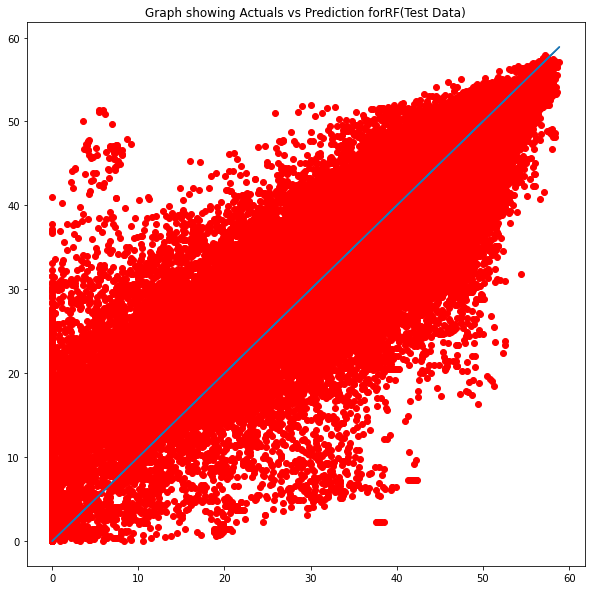

In [ ]:
scaleMakeEvaluate( 'RF', 5000 , latentVariables, predictand ) 


==================== Results RF ====================
R2 score =  0.9140329734072451
RMSE =  4.101953446054599
MSE =  16.826022073599205


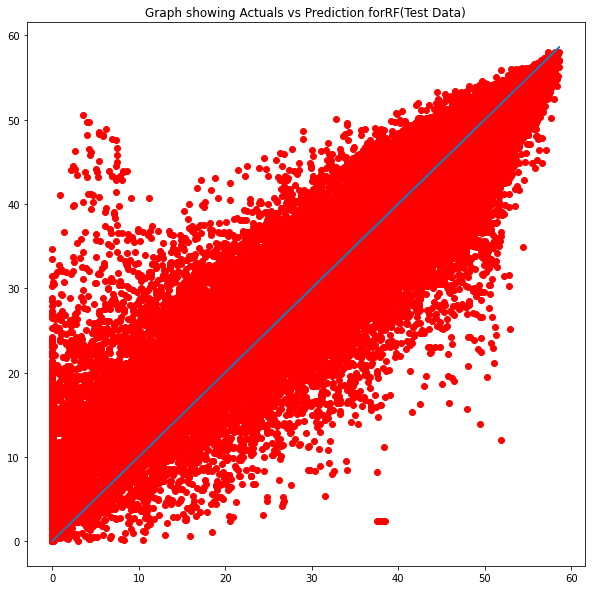

In [ ]:
scaleMakeEvaluate( 'RF', 25000 , latentVariables, predictand ) 

==================== Results RF ====================
R2 score =  0.9607597376251703
RMSE =  2.772536750769775
MSE =  7.686960034369021


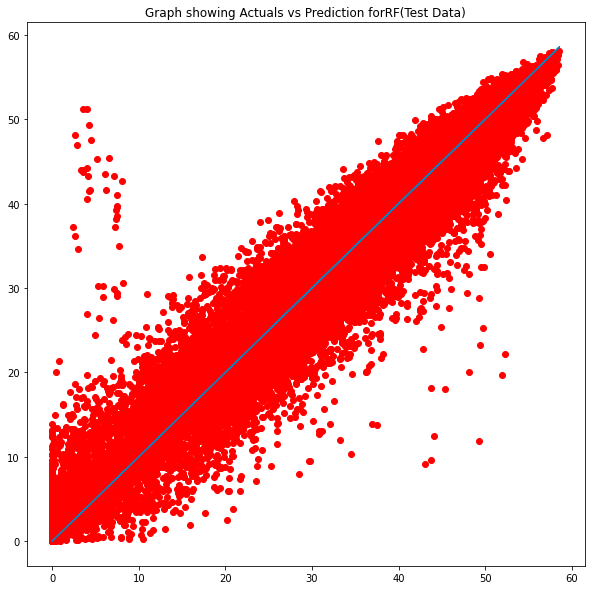

In [ ]:
scaleMakeEvaluate( 'RF', 75000 , latentVariables, predictand ) 

In [ ]:
for model in ['XGB', 'RF', 'SVM']:
    scaleMakeEvaluate( model, 5000 , featureCols,predictand ) 


[10:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Results ====================
R2 score =  0.9356026159823249
RMSE =  3.5452264673887988
MSE =  12.568630705074062
==================== Results ====================
R2 score =  0.9354480386397444
RMSE =  3.549478839060126
MSE =  12.598800028935619
[LibSVM]

[02:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------

XGBOOST Test isotherm1 MSE	12.640176144754834

XGBOOST Test isotherm1 RMSE	3.555302539131492

XGBOOST Test isotherm1 R2	0.9352428654290801

XGBOOST Train isotherm1 MSE	0.001076748346231336

XGBOOST Train isotherm1 RMSE	0.032813843819816904

XGBOOST Train isotherm1 R2	0.9999945220041967

--------------------------------------------------

--------------------------------------------------

RF Test isotherm1 MSE	12.658806045352549

RF Test isotherm1 RMSE	3.557921590669551

RF Test isotherm1 R2	0.9351474222195683

RF Train isotherm1 MSE	1.9858274137243057

RF Train isotherm1 RMSE	1.4091938879104982

RF Train isotherm1 R2	0.9898970318584241

--------------------------------------------------

[LibSVM]--------------------------------------------------

SVM Test isotherm1 MSE	88.67687216888064

SVM Test isotherm1 RM

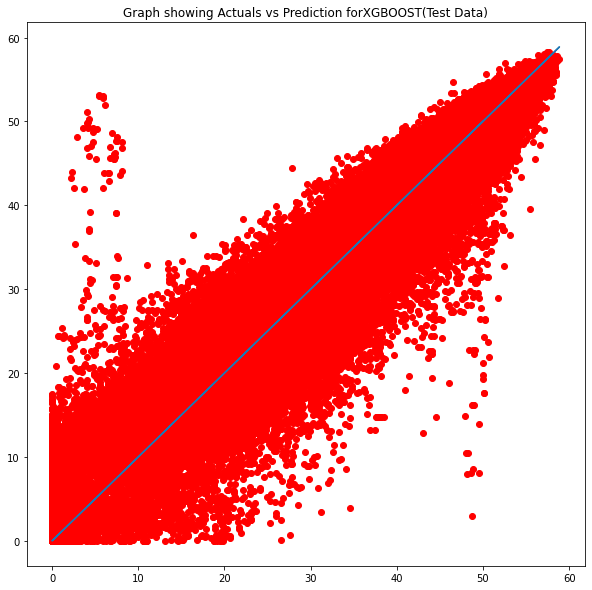

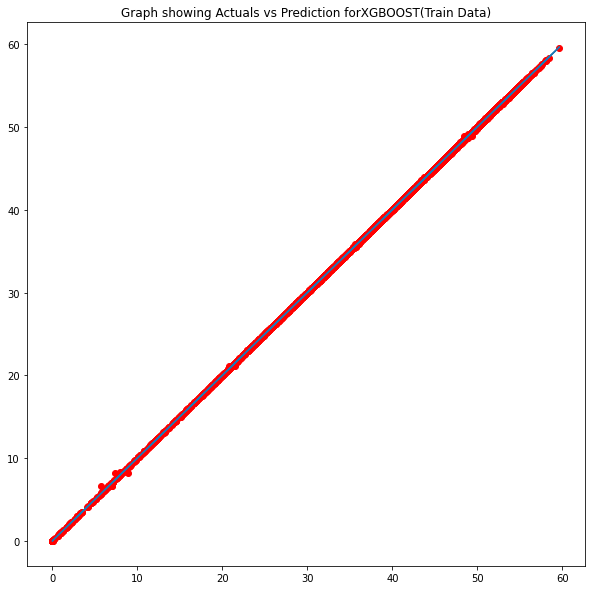

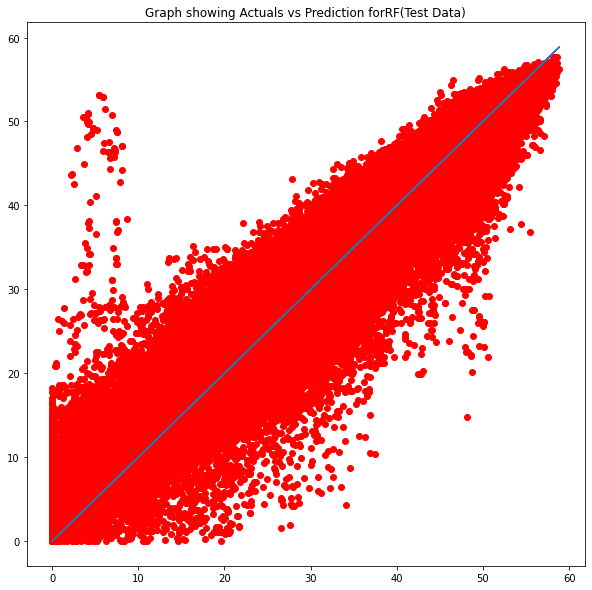

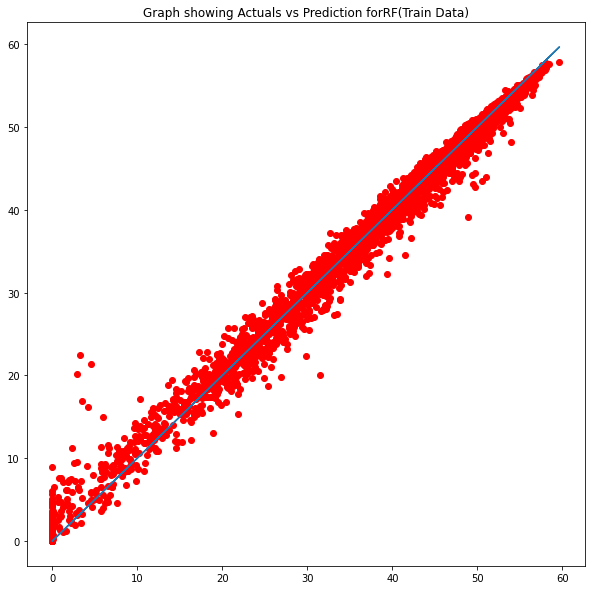

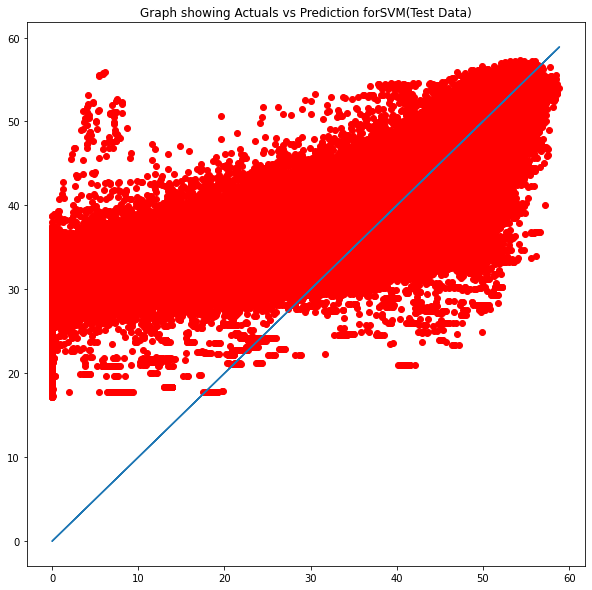

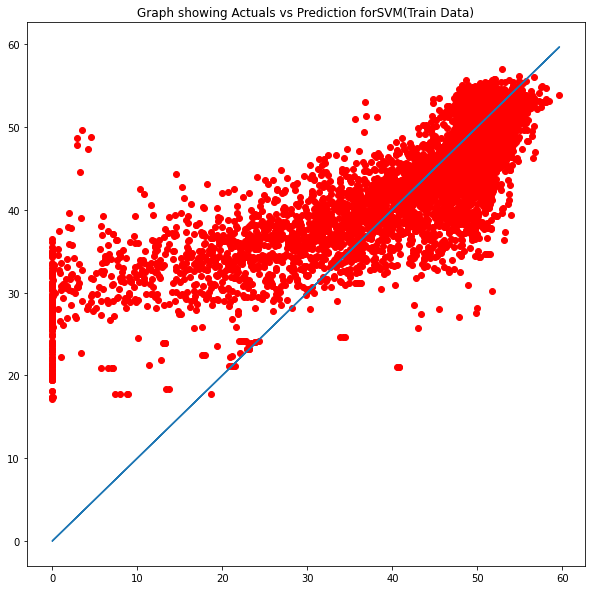

In [ ]:
for regr_choice in range(0, 3):
    regr_names = ['XGBOOST', 'RF', 'SVM']
    regr_objects = [XGBRegressor(n_estimators=100, max_depth=100, random_state=0),
                    RandomForestRegressor(
                        n_estimators=100, max_depth=100, random_state=0),
                    svm.SVR(kernel='rbf', epsilon=0.1, verbose=True)
                    # RVR(kernel='rbf', n_iter=10000, tol=0.0001, verbose=True),
                    # linear_model.HuberRegressor(
                    #     epsilon=1.35, max_iter=100, alpha=0.0001, warm_start=False, fit_intercept=True, tol=1e-05),

                    ]

    regr = regr_objects[regr_choice]
    regr_name = regr_names[regr_choice]

    regr.fit( TrainingFeaturesScaled , trainPredictand)

    y_predicted = regr.predict(TestFeaturesScaled)

    print('-'*50 + '\n' )
     
      
    print(regr_name+' Test '+predictandName+' MSE\t' +
          str(mean_squared_error(testPredictand, y_predicted))+'\n')
    print(regr_name +' Test '+predictandName+' RMSE\t' +
          str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')
    print(regr_name+' Test '+predictandName+' R2\t' +
          str(r2_score(testPredictand, y_predicted))+'\n')

    

    xPlot = testPredictand
    yPlot = y_predicted
    plt.figure(figsize=(10, 10))
    plt.plot(xPlot, yPlot, 'ro')
    plt.plot(xPlot, xPlot)
    plt.title('Graph showing Actuals vs Prediction for' + regr_name + '(Test Data)' )
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    plt.savefig(predictandName +'_'+regr_name +
                '_Regression_Correlation_Test', bbox_inches='tight')

    y_predicted = regr.predict(TrainingFeaturesScaled)

    print(regr_name+' Train '+predictandName+' MSE\t' +
          str(mean_squared_error(trainPredictand, y_predicted))+'\n')
    
    print(regr_name +' Train '+predictandName+' RMSE\t' +
          str(mean_squared_error(trainPredictand, y_predicted, squared=False ))+'\n')
    
    print(regr_name+' Train '+predictandName+' R2\t' +
          str(r2_score(trainPredictand, y_predicted))+'\n')

    print('-'*50 + '\n' )
    xPlot = trainPredictand
    yPlot = y_predicted
    plt.figure(figsize=(10, 10))
    plt.plot(xPlot, yPlot, 'ro')
    plt.plot(xPlot, xPlot)
    plt.title('Graph showing Actuals vs Prediction for' + regr_name + '(Train Data)' )
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    plt.savefig(predictandName+'_'+regr_name +
                '_Regression_Correlation_Train', bbox_inches='tight')

    joblib.dump(regr, predictandName +
                '_'+ regr_name +'_Regression.pkl') 

### Randon Forest Classifier 

In [ ]:


# numColumns = fullDataset.shape[1]

# X = fullDataset.iloc[:, 0:numColumns-7]
# #X.columns = column_names.columns

# y_list = [full_dataset_df.isotherm0_absorption,
#           full_dataset_df.isotherm1_absorption]
# y_names = ['isotherm0', 'isotherm1']

# choice = 1
# y = y_list[choice]
# y_name = full_dataset_df["isotherm1_absorption"]

# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
#         X, y, test_size=.981, random_state=15)
# scaler = StandardScaler().fit(X_train_scaled)
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)



RandomForestRegr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=0)
RandomForestRegr.fit( TrainingFeaturesScaled  , trainPredictand )
y_predicted = m.predict( TestFeaturesScaled )

r2 = r2_score( testPredictand , y_predicted)
print('\n--------R2=', r2)


print(regr_name +' Test '+predictandName+' RMSE\t' + str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')



--------R2= 0.9352428654290801
SVM Test isotherm1 RMSE	3.555302539131492



In [ ]:
featureImportances = RandomForestRegr.feature_importances_
#important Feature Variables
columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]

Index(['mean_atomic_numbers', 'volume_per_atom', 'max_distance_matrix',
       'std_distance_matrix', 'mean_van_der_waals_radius',
       'mean_average_cationic_radius'],
      dtype='object')

### Finding the next important Feature by elimination

In [ ]:

#featureCols_reduced =  featureCols.drop( list(columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]) , axis = 1  )
RandomForestRegr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=0)
RandomForestRegr.fit( TrainingFeaturesScaled[:,np.where(featureImportances < 0.01)[0]]   , trainPredictand )
y_predicted = RandomForestRegr.predict(  TestFeaturesScaled[:,np.where(featureImportances < 0.01)[0]]  )

r2 = r2_score( testPredictand , y_predicted)
print('-'*50)
print('R2=', r2)


print('Random Forest Regr' +' Test '+predictandName+' RMSE\t' + str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')

featureImportances2 =  RandomForestRegr.feature_importances_
#important Feature Variables
print('-'*50)
columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]

--------------------------------------------------
R2= 0.8959619111553851
Random Forest Regr Test isotherm1 RMSE	4.5063916563571995

--------------------------------------------------


Index(['std_atomic_numbers', 'empty_volume', 'min_superconduction_temperature',
       'min_liquid_range', 'min_coefficient_of_linear_thermal_expansion'],
      dtype='object')

In [ ]:
3 0.7187286599248028 empty_volume
5 0.048054497916286465 mean_distance_matrix
25 0.011031973470643658 std_poissons_ratio
49 0.020982322334397722 std_liquid_range
53 0.016877886856972304 std_bulk_modulus
81 0.018628205440220924 std_average_ionic_radius
84 0.0115045442419903 std_average_cationic_radius

array([[[-0.40991494, -0.21679973, -0.57586972, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.59573608, -0.21679973,  3.01860264, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.07563977, -0.21679973, -0.90606433, ...,  0.        ,
          0.        ,  0.        ]],

       ...,

       [[-0.07563977, -0.21679973, -0.95048215, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.40991494, -0.21679973,  0.00650246, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.40991494, -0.21679973, -0.82442253, ...,  0.        ,
          0.        ,  0.        ]]])